In [9]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

In [10]:
df = pd.read_csv('data/ETH_USDT-1h_processed.csv')
print(df.shape)
print(df.columns)

df = df[1000:2000]

df.head()

(48766, 26)
Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'returns',
       'range', 'benchmark_cummulative_returns', 'rsi', 'rsi_returns', 'ma_12',
       'ma_21', 'dow', 'roll_returns', 'avg_range', 'open_change',
       'high_change', 'low_change', 'volume_change', 'returns_T1', 'range_T1',
       'rsi_returns_T1', 'returns_T2', 'range_T2', 'rsi_returns_T2'],
      dtype='object')


,timestamp,open,high,low,close,volume,returns,range,benchmark_cummulative_returns,rsi,...,open_change,high_change,low_change,volume_change,returns_T1,range_T1,rsi_returns_T1,returns_T2,range_T2,rsi_returns_T2
1000,2017-09-29 08:00:00,290.47,295.00,287.31,290.96,364.89264,0.001618,0.026766,-0.337206,44.705647,...,0.020697,0.013746,0.010054,-0.231301,0.020767,0.023027,1.226013,0.005583,0.020981,1.071439
1001,2017-09-29 09:00:00,290.36,290.95,287.21,287.60,416.80517,-0.011548,0.013022,-0.344860,41.285957,...,-0.000379,-0.013729,-0.000348,0.142268,0.001618,0.026766,1.013635,0.020767,0.023027,1.226013
1002,2017-09-29 10:00:00,287.60,290.75,285.55,289.93,555.18484,0.008102,0.018210,-0.339393,44.458747,...,-0.009505,-0.000687,-0.005780,0.332001,-0.011548,0.013022,0.923507,0.001618,0.026766,1.013635
1003,2017-09-29 11:00:00,290.00,299.11,289.94,297.01,498.20789,0.024420,0.031627,-0.323261,52.804441,...,0.008345,0.028753,0.015374,-0.102627,0.008102,0.018210,1.076849,-0.011548,0.013022,0.923507
1004,2017-09-29 12:00:00,297.01,302.97,295.32,300.82,563.66167,0.012828,0.025904,-0.313668,56.585056,...,0.024172,0.012905,0.018556,0.131378,0.024420,0.031627,1.187718,0.008102,0.018210,1.076849


[-1.  1. nan]


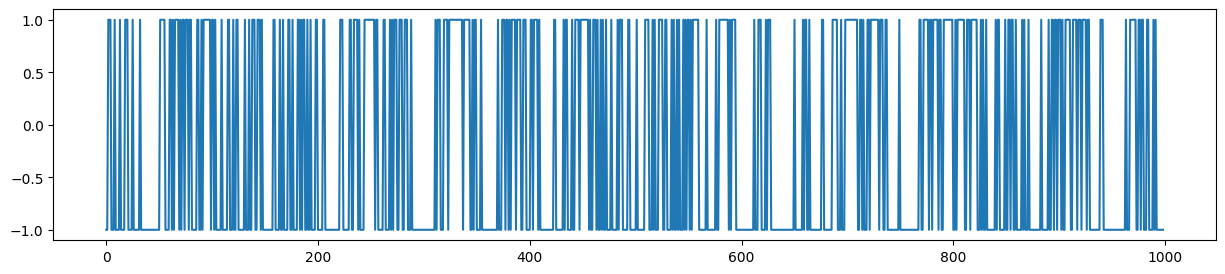

In [11]:
# Binary Labeling Based on Returns
## positive returns as class 1 and negative returns as class 0
# df["&-range"] = 0
df.loc[df["range"].shift(-1) > df["avg_range"], "&-range"] = 1
df.loc[df["range"].shift(-1) < df["avg_range"], "&-range"] = -1

print(df['&-range'].unique())


fig = plt.figure(figsize = (15, 3))
plt.plot(df["&-range"][:-1].values)
plt.show()

In [4]:
df['&-range']

1000   -1.0
1001   -1.0
1002    1.0
1003    1.0
1004    1.0
       ... 
1995   -1.0
1996   -1.0
1997   -1.0
1998   -1.0
1999    NaN
Name: &-range, Length: 1000, dtype: float64

[nan  1. -1.]


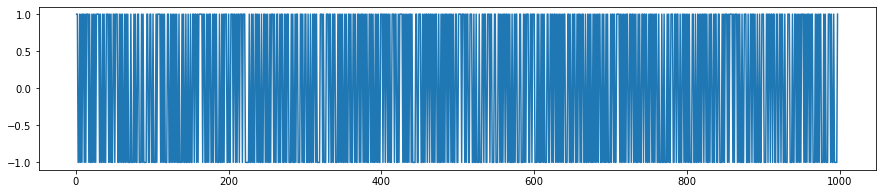

In [5]:
## label: Raw Returns 

def calculate_returns(df):
    multiplier_1 = 1
    multiplier_2 = 1

    # Assume open price on following day to avoid lookahead bias for close calculation
    log_rets = np.log(df["open"].shift(-1) / df["close"].shift(1)) * multiplier_1 * multiplier_2
    return log_rets

df['log_returns'] = calculate_returns(df)
df['log_returns_diff'] = df['log_returns'] - df['log_returns'].shift(1)  

# df["&-raw_returns"] = 0
df.loc[df["log_returns_diff"].shift(-1) > 0, "&-raw_returns"] = 1
# df.loc[df["log_returns"].shift(-1) == np.nan, "&-raw_returns"] = 0
df.loc[df["log_returns_diff"].shift(-1) < 0, "&-raw_returns"] = -1

print(df['&-raw_returns'].unique())

fig = plt.figure(figsize = (15, 3))
plt.plot(df["&-raw_returns"].values)
plt.show()

In [6]:
df['&-raw_returns']

1000    NaN
1001    1.0
1002    1.0
1003   -1.0
1004   -1.0
       ... 
1995   -1.0
1996   -1.0
1997    1.0
1998    NaN
1999    NaN
Name: &-raw_returns, Length: 1000, dtype: float64

In [7]:
## Label: Fixed Horizon Method
# fig = plt.figure(figsize = (15, 3))

# price = df['close'].pct_change()*100
# price.plot()

<AxesSubplot: >

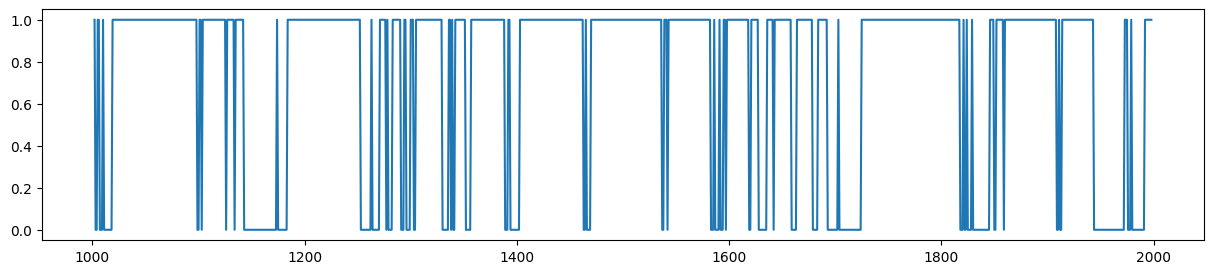

In [12]:
## Double Barrier Method
### 0 => Buy
### 1 => Sell


def double_barrier_method(data, tp, sl):    
    d = pd.DataFrame(data, columns=['price'])
    d['returns'] =  d['price'].pct_change()
    d['cumulative_returns'] = (1 + d['returns']).cumprod() - 1
    d['action'] = np.nan

    for i in range(len(d['action'])):
        threshould = 0
        for j in range(i, len(d['cumulative_returns'])):
            ## Calculate threshould
            threshould = threshould + d['returns'].iloc[j]
            
            if threshould >= tp:
                d['action'].iloc[i] = 0
                break

            if threshould <= sl:
                d['action'].iloc[i] = 1
                break

    return np.array(d['action'].shift())


df['&-dbm'] =  double_barrier_method(np.array(df['close']), 0.03, -0.01)

fig = plt.figure(figsize = (15, 3))
df['&-dbm'].plot()

In [13]:
df.dropna(inplace=True)

In [14]:
df['&-dbm']

1002    1.0
1003    0.0
1004    0.0
1005    1.0
1006    1.0
       ... 
1994    1.0
1995    1.0
1996    1.0
1997    1.0
1998    1.0
Name: &-dbm, Length: 997, dtype: float64

In [17]:
# dataframe['&-dbm'] =  self.double_barrier_method(np.array(dataframe['close']), 0.03, -0.01)
df['&-dbm'] = np.where(df["&-dbm"] == 1, 1, 0)

In [18]:
df['&-dbm'].unique()

array([1, 0])

In [ ]:
## Triple  Barrier Method

